# GPI no Cliff World com Sarsa, Q-Learning e Expected Sarsa

#### O envirorment usado neste teste srá o do Cliff World, em que o estado inicial é no canto direito inferior e o estado terminal é no canto esquerdo inferior, o objetivo do agente é descobrir o melhor caminho entre o estado inicial e o estado final sendo que:
* Os estados entre o inicial e o final são o precipicio (cliff) e caso o agente entre neles ele recebe um reward de $-100$ e volta para o estado inicial sem o episode ser terminado
* Para cada transição para um estado que não seja o terminal o agente recebe um reward de $-1$
* Se chocar nas bordas apenas mantem no estado atual recebendo o reward de transição
* Se atingir o estado terminal o episode é encerrado

<img src="images/cliffworld.png" alt="Drawing" style="width: 600px;"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Criação da classe do envirorment
class CliffWorld:
    def __init__(self, env_map = 1, num_lines=4, num_cols=12):
        self.num_cols = num_cols
        self.num_lines = num_lines
        self.init_state = self.num_cols * (self.num_lines - 1)
        self.terminal_state = (self.num_cols * self.num_lines) - 1
        if(env_map == 1): self.cliff = [i for i in range(self.init_state+1, self.terminal_state)]
        elif(env_map == 2): self.cliff = [14, 26, 38, 6, 18, 30, 33, 45]
        self.cliff_reward = -100
        self.step_reward = -1
        self.terminal_reward = 0
        self.terminal = False
        self.state = None
        self.num_states = self.num_cols * self.num_lines
        self.num_actions = 4
    #-------------------------------------------------------- 
    def envInit(self):
        self.state = self.init_state
        self.terminal = False
        return self.state, self.terminal
    #-------------------------------------------------------- 
    def envStep(self, action):
        #Se ainda não tiver atingido o estado terminal
        if (self.terminal == False):
            #action = 0 -> CIMA
            if (action == 0): 
                #Se o estado atual não estiver na borda superior pode ir para cima
                if (self.state >= self.num_cols):
                    self.state = self.state - self.num_cols
                reward = self.step_reward

            #action = 1 -> DIREITA
            elif (action == 1):
                #Se o estado atual não estiver na borda da direita pode ir para a direita
                if((self.state + 1) % self.num_cols != 0):
                    self.state = self.state + 1
                reward = self.step_reward

            #action = 2 -> BAIXO
            elif (action == 2):
                if(self.state < (self.num_lines - 1) * self.num_cols):
                    self.state = self.state + self.num_cols
                reward = self.step_reward

            #action = 3 -> ESQUERDA
            elif (action == 3):
                if(self.state % self.num_cols != 0):
                    self.state = self.state - 1
                reward = self.step_reward

            #Se o estado atual estiver no cliff volta p/ o estado inicial e o reward é de -100
            if self.state in self.cliff:
                self.state = self.init_state
                reward = self.cliff_reward

            #Ainda não atingiu o estado terminal
            self.terminal = False

            #Se o estado for o terminal o reward é 0 e terminal = True
            if(self.state == self.terminal_state):
                reward = self.terminal_reward
                self.terminal = True
        
        #Se ja tiver atingido o estado terminal
        else:
            self.terminal = True
            reward = 0
            
        return self.state, reward, self.terminal      
    #-------------------------------------------------------- 
    def getNumStates(self):
        return self.num_states
    #-------------------------------------------------------- 
    def getNumActions(self):
        return self.num_actions

In [3]:
env = CliffWorld()
state, terminal = env.envInit()
print("Estado Inicial: ", state)
print("Terminal :", terminal)

Estado Inicial:  36
Terminal : False


In [4]:
class TdAgent:
    def __init__(self, td_type, step_size = 0.5, discount = 1.0, epsilon = 0.1):
        self.td_type = td_type
        self.step_size = step_size
        self.discount = discount
        self.epsilon = epsilon
    
    #-------------------------------------------------------- 
    def train(self, env, num_episodes):
        
        #Pega o numero de estados e onumero de ações do ambiente
        num_states = env.getNumStates()
        num_actions = env.getNumActions()
        
        #Inicializa os action-values como zero
        self.q_values = np.zeros((num_states, num_actions))
        
        #Vetor que ira armazenar a soma das rewards em cada episodio
        rewards = np.zeros(num_episodes)
        
        #Vetor com o numero de visitas em cada estado nos ultimos 10 episodios
        visits = np.zeros(num_states)
        
        #Reliza todos os episodes
        for episode in range(num_episodes):
            
            #Armazena o estado inicial e a ação inicial
            prev_state, terminal = env.envInit()
            
            #Escolhe a ação de acordo com o metodo epsilon-soft
            if(np.random.rand() < self.epsilon):
                prev_action = np.random.randint(num_actions)
            else:
                prev_action = self.argmax(self.q_values[prev_state, :], num_actions)
            
            #Enquanto não atingir o estado terminal
            while(terminal is False):
                
                #Realiza a acao no ambiente baseado no ultimo estado
                state, reward, terminal = env.envStep(prev_action)
                
                #Ecolhe uma nova acao baseando no estado atual
                if(np.random.rand() < self.epsilon):
                    action = np.random.randint(num_actions)
                else:
                    action = self.argmax(self.q_values[state, :], num_actions)
                
                #Atualiza o valor de Q(S, A) para o estado e ação anteriores de acordo com o metodo escolhido
                if(self.td_type == "sarsa"):
                    self.q_values[prev_state, prev_action] = self.q_values[prev_state, prev_action] + self.step_size*(reward + self.discount*self.q_values[state, action] - self.q_values[prev_state, prev_action])
                
                elif(self.td_type == "q"):
                    self.q_values[prev_state, prev_action] = self.q_values[prev_state, prev_action] + self.step_size*(reward + self.discount*np.amax(self.q_values[state, :]) - self.q_values[prev_state, prev_action])
                
                elif(self.td_type == "ex-sarsa"):
                    current_q = self.q_values[state, :]
                    t_error = 0
                    top = float("-inf")
                    ties = []
                    for i in range(len(current_q)):
                        if current_q[i] > top:
                            top = current_q[i]
                            ties = []
                        if current_q[i] == top:
                            ties.append(i)
                    for i in range(len(current_q)):
                        if i in ties:
                            t = self.q_values[state, i]*((1 - self.epsilon)/len(ties) + (self.epsilon/num_actions))
                        else:
                            t = self.q_values[state, i]*(self.epsilon/num_actions)
                        t_error += t
                    self.q_values[prev_state, prev_action] += self.step_size*(reward + self.discount*t_error - self.q_values[prev_state, prev_action])
                
                #Os estado e ação atuais passam a ser os anteriores
                prev_state = state
                prev_action = action
                
                #Adiciona o reward ao reward total do episodio
                rewards[episode] += reward
                
                #Se estiver nos ultimos 10 episodios começa a armazenar as visitas em cada episodio
                if(num_episodes - episode <=10):
                    visits[prev_state] += 1
             
            #Armazenas as visitas no estado terminal
            if(num_episodes - episode <=10):
                visits[-1] += 1  
        
        #Retorna os rewards de cada episodio, os action-values finais e o numero de visitas em cada episodio  
        return rewards, self.q_values, visits
    
    #-------------------------------------------------------- 
    def argmax(self, q_values, act_num):
        '''Funcao que retorna o indice do valor maximo de um vetor q_values, 
        caso haja mais de um valor maximo entao retorna um deles aletoriamente'''
        top_value = float("-inf") #maior Q(a)
        ties = [] #Acoes que empataram entre o maior valor de Q(a)
        for i in range(act_num):
            if(q_values[i] > top_value):     #Se o Q(a) for maior que o maximo ate o momento:
                top_value = q_values[i]          #Substitui o Q(a) maximo pelo valor do atual
                ties = []                        #Zera o vetor de empates das acoes com o Q(a) maximo
                ties.append(i)                   #Adiciona a acao atual no vetor de empates
            elif(q_values[i] == top_value):  #Se o Q(a) for igual ao maximo ate o momento:
                ties.append(i)                   #Adiciona a ação ao vetor de empates
        return np.random.choice(ties)            #Retorna um valor aleatorio do vetor de empates do Q maximo

Sarsa finished
Q-learning finished
Expected-Sarsa finished


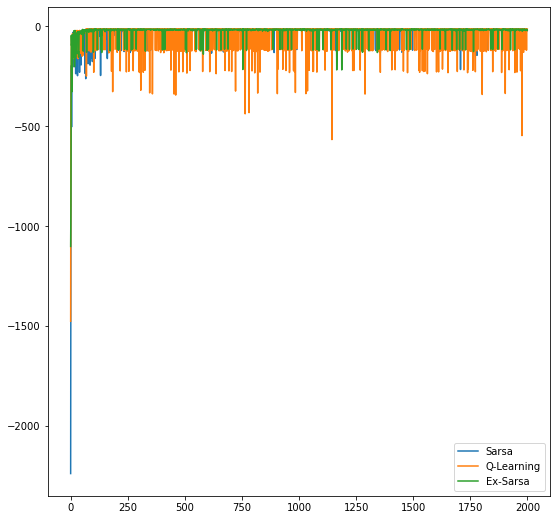

In [5]:
num_lines=4
num_cols=12
env = CliffWorld(env_map=1, num_lines=num_lines, num_cols=num_cols)

num_episodes = 2000
t = np.arange(num_episodes)

s_agent = TdAgent("sarsa", step_size = 0.1, discount=0.8, epsilon=0.1)
s_returns, s_Qvalues , s_visits = s_agent.train(env, num_episodes)
print("Sarsa finished")

q_agent = TdAgent("q", step_size = 0.3, discount=0.8, epsilon=0.08)
q_returns, q_Qvalues, q_visits = q_agent.train(env, num_episodes)
print("Q-learning finished")

es_agent = TdAgent("ex-sarsa", step_size = 0.3, discount = 1, epsilon=0.1)
es_returns, es_Qvalues, es_visits = es_agent.train(env, num_episodes)
print("Expected-Sarsa finished")

plt.figure(figsize=(9, 9))
plt.plot(t, s_returns, label='Sarsa')
plt.plot(t, q_returns, label="Q-Learning")
plt.plot(t, es_returns, label="Ex-Sarsa")
plt.legend()

### A célula abaixo plota o CliffWorld com o numero de visitas em cada estado nos ultimos 10 episodios do treinamento

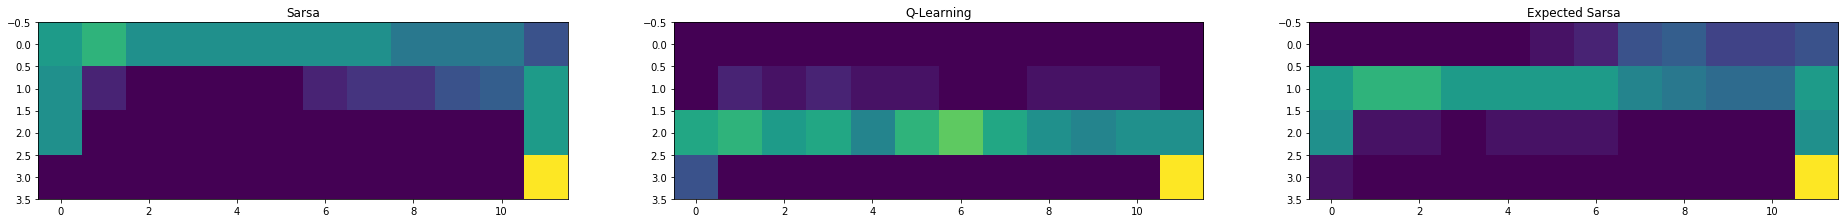

In [6]:
plt.figure(figsize=(5, 5)) 
plt.subplot(131)
plt.imshow(s_visits.reshape(num_lines, num_cols))
plt.title("Sarsa")
plt.subplot(132)
plt.imshow(q_visits.reshape(num_lines, num_cols))
plt.title("Q-Learning")
plt.subplot(133)
plt.imshow(es_visits.reshape(num_lines, num_cols))
plt.title("Expected Sarsa")
plt.subplots_adjust(left=0, bottom=0, right=5, top=10, wspace=0.2, hspace=0.2)
plt.show()